In [1]:
# --- 0) Setup: Splink demo data + a tiny link_only model ---------------------
import pandas as pd
import numpy as np

from splink import splink_datasets
import splink.comparison_library as cl
from splink import DuckDBAPI, Linker, SettingsCreator, block_on

# Use the same demo data and pattern as the docs
df = splink_datasets.fake_1000  # persons-like fake data
df_l = df.sample(frac=0.5, random_state=42)  # left table
df_r = df.drop(df_l.index)                   # right table

settings = SettingsCreator(
    link_type="link_only",
    blocking_rules_to_generate_predictions=[
        block_on("first_name"),
        block_on("surname"),
    ],
    comparisons=[
        cl.NameComparison("first_name"),
        cl.NameComparison("surname"),
        cl.DateOfBirthComparison("dob", input_is_string=True, invalid_dates_as_null=True),
        cl.ExactMatch("city").configure(term_frequency_adjustments=True),
        cl.EmailComparison("email"),
    ],
)

linker = Linker(
    [df_l, df_r],
    settings,
    db_api=DuckDBAPI(),
    input_table_aliases=["df_left", "df_right"],
)

# Train quickly (mirrors the example’s EM sessions)
linker.training.estimate_probability_two_random_records_match(
    [
        "l.first_name = r.first_name and levenshtein(r.dob, l.dob) <= 1",
        "l.surname = r.surname and levenshtein(r.dob, l.dob) <= 1",
        "l.first_name = r.first_name and levenshtein(r.surname, l.surname) <= 2",
        block_on("email"),
    ],
    recall=0.7,
)
linker.training.estimate_u_using_random_sampling(max_pairs=1e6, seed=1)
linker.training.estimate_parameters_using_expectation_maximisation(block_on("dob"))
linker.training.estimate_parameters_using_expectation_maximisation(block_on("email"))
linker.training.estimate_parameters_using_expectation_maximisation(block_on("first_name"))

# IMPORTANT: For record-level distributions you want *all scored* edges, so no threshold
pred = linker.inference.predict()  # don't pass threshold to avoid filtering
df_pred = pred.as_pandas_dataframe()  # contains match_weight and match_probability
# Columns include: match_weight, match_probability, unique_id_l, unique_id_r, ... (see docs)


downloading: https://raw.githubusercontent.com/moj-analytical-services/splink_datasets/master/data/fake_1000.csv



Probability two random records match is estimated to be  0.00338.
This means that amongst all possible pairwise record comparisons, one in 295.61 are expected to match.  With 250,000 total possible comparisons, we expect a total of around 845.71 matching pairs
You are using the default value for `max_pairs`, which may be too small and thus lead to inaccurate estimates for your model's u-parameters. Consider increasing to 1e8 or 1e9, which will result in more accurate estimates, but with a longer run time.
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - first_name (no m values are trained).
    - surname (no m values are trained).
    - dob (no m values are trained).
    - city (no m values are trained).
    - email (no m values are trained).

----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l."dob" = r."dob"

Parameter estimates will be made for the following comparison(s):
    - first_name
    - surname
    - city
    - email

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - dob

Level Jaro-Winkler >0.88 on username on comparison email not observed in dataset, unable to train m value

Iteration 1: Largest change in params was -0.392 in the m_probability of surname, level `Exact match on surname`
Iteration 2: Largest change in params was 0.112 in probability_two_random_records_match
Iteration 3: Large

In [5]:
df_pred

,match_weight,match_probability,source_dataset_l,source_dataset_r,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,surname_l,...,dob_l,dob_r,gamma_dob,city_l,city_r,gamma_city,email_l,email_r,gamma_email,match_key
0,-13.016307,0.000121,df_left,df_right,521,579,George,Jessica,0,Owen,...,1980-06-29,1974-11-17,1,London,Walsall,0,go94@bradshaw-sanders.com,jessica.owen@elliott.org,0,1
1,-8.692923,0.002411,df_left,df_right,513,944,Theo,Francesca,0,White,...,2001-07-09,2015-12-07,0,Kingston-upon-Hull,Hudersfield,0,t.white@west-waller.net,None,-1,1
2,-13.016307,0.000121,df_left,df_right,859,301,Theodore,Harrosin,0,Marshall,...,1972-07-25,1974-09-11,1,Birmingham,Southampton,0,theodore.m@taylorcom,harrisonmk@ptrick.com,0,1
3,-18.066141,0.000004,df_left,df_right,636,153,Jacob,Jacob,4,Adasm,...,2000-09-03,2019-11-21,0,Londn,Bolton,0,jacob.a83@clark.com,js37@rodriguez-vega.com,0,0
4,-17.750969,0.000005,df_left,df_right,280,200,Lola,George,0,Taylor,...,2016-11-20,1984-10-27,0,Aberdeen,Huddersfield,0,lolat86@bishop-giles.com,g.t51@rodriguez.com,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,-8.364591,0.003025,df_left,df_right,113,262,Oliver,Oliver,4,Atkinson,...,2011-01-21,1983-04-08,0,London,None,-1,None,ohughes@page-kim.info,-1,0
1721,-16.651104,0.000010,df_left,df_right,65,766,Adam,Adam,4,Jones,...,1992-09-11,1971-08-28,0,oBristl,Cardiff,0,ajones6@cortez-wilcox.com,adam.edwards38@bullock-edwards.com,0,0
1722,-11.687974,0.000303,df_left,df_right,544,262,Oliver,Oliver,4,Jones,...,1981-09-02,1983-04-08,1,London,None,-1,oliverjones82@bond.biz,ohughes@page-kim.info,0,0
1723,-10.689920,0.000605,df_left,df_right,604,103,Alfie,Alfie,4,King,...,1996-08-02,2009-04-07,0,Leicester,Plyoutm,0,None,None,-1,0


In [25]:
import numpy as np
import pandas as pd

def _entropy_bits(p, eps=1e-12):
    p = np.asarray(p, dtype=float)
    s = p.sum()
    if s <= 0:
        return 0.0
    p = p / s
    # clip to avoid log(0) and tiny >1 rounding
    p = np.clip(p, eps, 1 - eps)
    p = p / p.sum()
    H = -(p * (np.log(p) / np.log(2.0))).sum()
    return float(max(H, 0.0))

def compute_perplexity_metrics_from_splink(
    df_edges: pd.DataFrame,
    *,
    source_col: str = "unique_id_l",
    candidate_col: str = "unique_id_r",
    weight_col: str = "match_weight",   # base-2 log-odds from Splink
    prob_col: str | None = None,        # alternatively, a calibrated match_probability in (0,1)
    # prior for "no-match":
    prior: float | dict | pd.Series | str | None = None,  # scalar odds or prob col/series/dict
    prior_is_odds: bool = True,         # set False if 'prior' is a probability pi0
    prior_default_odds: float = 1.0,    # O0 fallback: neutral when starting from Splink posteriors
    # candidate trimming (optional, improves robustness to dust tails):
    topk: int | None = None,            # keep top-k candidates by strength (after odds)
    min_cum_mass: float | None = None,  # keep smallest k with cumulative O_i / sum(O_i) >= this (e.g., 0.99)
    # outputs:
    return_edge_probs: bool = True,
    all_source_ids: list | pd.Series | None = None,  # to include zero-candidate records
    eps: float = 1e-12,
):
    """
    Build a per-record probability distribution over {candidates + no-match} and compute:
      - p_null, matchability
      - H_cond (bits), perp_cond (effective # candidates), H_all/Perp_all (incl. null)
      - top1, margin (within conditional candidate distribution)
      - n_candidates (raw), n_kept (after trimming)
    Optionally returns edge-level probabilities p_i and p_cond.

    'prior' can be:
      - None (use prior_default_odds)
      - scalar (applied to all records)
      - dict mapping source_id -> prior (odds or prob depending on prior_is_odds)
      - pandas Series indexed by source_id
      - str naming a column in df_edges with per-edge prior (first per source is used)
    """

    df = df_edges.copy()

    # --- derive odds per edge (vs no-match) ---
    if prob_col is not None:
        q = df[prob_col].astype(float).clip(eps, 1 - eps)
        df["_Oi"] = q / (1.0 - q)
        df["_score_for_sort"] = df["_Oi"]
    else:
        # stable exponentiation: for each record, subtract max weight before exp2
        # we compute within-group later; keep weight column as float
        df["_Mi"] = df[weight_col].astype(float)
        df["_score_for_sort"] = df["_Mi"]  # used only for sorting before converting to odds

    # --- resolve per-record prior odds O0 ---
    def _lookup_prior(sid, g):
        if prior is None:
            return prior_default_odds
        if isinstance(prior, (int, float)):
            return float(prior) if prior_is_odds else float(prior) / (1 - float(prior))
        if isinstance(prior, str):
            val = g[prior].iloc[0]
            return float(val) if prior_is_odds else float(val) / (1 - float(val))
        if isinstance(prior, pd.Series):
            v = prior.get(sid, np.nan)
            if pd.isna(v):
                return prior_default_odds
            return float(v) if prior_is_odds else float(v) / (1 - float(v))
        if isinstance(prior, dict):
            v = prior.get(sid, None)
            if v is None:
                return prior_default_odds
            return float(v) if prior_is_odds else float(v) / (1 - float(v))
        return prior_default_odds

    rec_rows = []
    edge_rows = []

    # Precompute raw candidate counts
    n_cand_map = df.groupby(source_col, sort=False)[candidate_col].size() if len(df) else pd.Series(dtype=int)

    for sid, g in df.groupby(source_col, sort=False):
        g = g.copy()
        O0 = _lookup_prior(sid, g)

        # Compute odds O_i stably
        if prob_col is not None:
            Oi = g["_Oi"].to_numpy(dtype=float)
            # for trimming & ranking, use Oi directly
            sort_strength = Oi
            exp_scale = 1.0  # already odds scale
        else:
            M = g["_Mi"].to_numpy(dtype=float)
            mmax = np.max(M) if M.size else 0.0
            # scaled odds: 2^(M - mmax); later we scale O0 by 2^(-mmax)
            Oi = np.power(2.0, M - mmax)
            sort_strength = M  # sorting by weight is equivalent
            exp_scale = np.power(2.0, -mmax)

        # --- optional trimming ---
        keep_idx = np.arange(len(Oi))
        if len(Oi) and (topk is not None or min_cum_mass is not None):
            order = np.argsort(-sort_strength)  # descending
            Oi_sorted = Oi[order]
            if min_cum_mass is not None:
                # choose smallest k with cumulative share >= min_cum_mass
                cs = np.cumsum(Oi_sorted)
                k = np.searchsorted(cs / cs[-1], min_cum_mass, side="left") + 1
            else:
                k = len(Oi_sorted)
            if topk is not None:
                k = min(k, int(topk))
            keep_ord = order[:k]
            keep_idx = np.sort(keep_ord)
            Oi = Oi[keep_idx]

        # --- normalisation over {candidates + null} ---
        if prob_col is not None:
            Z = O0 + Oi.sum()
            p_i = Oi / Z if Z > 0 else np.zeros_like(Oi)
            p_null = O0 / Z if Z > 0 else 1.0
        else:
            # scale O0 to match the exp scaling
            O0_scaled = O0 * exp_scale
            Z = O0_scaled + Oi.sum()
            p_i = Oi / Z if Z > 0 else np.zeros_like(Oi)
            p_null = O0_scaled / Z if Z > 0 else 1.0

        matchability = 1.0 - p_null

        # conditional distribution over candidates (given it links)
        if matchability > eps and p_i.size:
            p_cond = p_i / matchability
            # entropy/perplexity
            H_cond = _entropy_bits(p_cond, eps=eps)
            perp_cond = float(2.0 ** H_cond)
            # diagnostics: top1 and margin
            ord_pc = np.sort(p_cond)[::-1]
            top1 = float(ord_pc[0])
            margin = float(ord_pc[0] - ord_pc[1]) if ord_pc.size >= 2 else float("nan")
        else:
            p_cond = np.zeros_like(p_i)
            H_cond, perp_cond = 0.0, 1.0
            top1, margin = 0.0, float("nan")

        # unconditional entropy/perplexity (incl. null) for dataset QA
        if p_i.size:
            H_all = _entropy_bits(np.r_[p_i, p_null], eps=eps)
            perp_all = float(2.0 ** H_all)
        else:
            # no candidates in this group (shouldn't happen here, but safe)
            H_all, perp_all = _entropy_bits([p_null], eps=eps), 1.0

        # record row
        rec_rows.append({
            source_col: sid,
            "p_null": float(p_null),
            "matchability": float(matchability),
            "H_cond": H_cond,
            "perp_cond": perp_cond,
            "H_all": H_all,
            "perp_all": perp_all,
            "top1": top1,
            "margin": margin,
            "n_candidates": int(n_cand_map.get(sid, 0)),
            "n_kept": int(len(Oi)),
            "trimmed": bool(len(Oi) != int(n_cand_map.get(sid, 0))),
        })

        # edge rows (optional)
        if return_edge_probs:
            kept_mask = np.zeros(len(g), dtype=bool)
            kept_mask[keep_idx] = True
            g = g.iloc[keep_idx].copy()  # keep only trimmed set in edge output
            g["p_i"] = p_i
            g["p_cond"] = p_cond
            # rank by p_cond desc (ties arbitrary)
            if p_cond.size:
                g["rank_cond"] = (np.argsort(-p_cond) + 1)
            else:
                g["rank_cond"] = []
            edge_rows.append(g)

    record_metrics = pd.DataFrame(rec_rows)

    # --- Add zero-candidate records (ensure full coverage) ---
    if all_source_ids is not None:
        all_ids = pd.Series(all_source_ids, name=source_col).drop_duplicates()
        record_metrics = all_ids.to_frame().merge(record_metrics, on=source_col, how="left")
        # fill metrics for records with no candidates
        for col, val in [
            ("p_null", 1.0),
            ("matchability", 0.0),
            ("H_cond", 0.0),
            ("perp_cond", 1.0),
            ("H_all", 0.0),
            ("perp_all", 1.0),
            ("top1", 0.0),
            ("margin", np.nan),
            ("n_candidates", 0),
            ("n_kept", 0),
            ("trimmed", False),
        ]:
            record_metrics[col] = record_metrics[col].fillna(val)
        record_metrics["zero_candidate"] = record_metrics["n_candidates"].eq(0)
    else:
        record_metrics["zero_candidate"] = record_metrics["n_candidates"].eq(0)

    edges_enriched = (pd.concat(edge_rows, ignore_index=True) if return_edge_probs and edge_rows else None)
    return record_metrics, edges_enriched

all_source_ids = df_l["unique_id"].tolist()

record_metrics, edges_enriched = compute_perplexity_metrics_from_splink(
    df_pred,
    source_col="unique_id_l",
    candidate_col="unique_id_r",
    weight_col="match_weight",
    # prob_col="match_probability",  # use this instead of weight_col if you prefer
    prior=None,                     # defaults to neutral odds=1 for no-match
    topk=None,                      # or e.g., topk=5
    min_cum_mass=None,              # or e.g., 0.99
    all_source_ids=all_source_ids,
)

print(len(record_metrics))  # should be 500 in the demo



500


C:\Users\uctvjla\AppData\Local\Temp\ipykernel_29024\2890803316.py:213: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  record_metrics[col] = record_metrics[col].fillna(val)


In [29]:
record_metrics

,unique_id_l,p_null,matchability,H_cond,perp_cond,H_all,perp_all,top1,margin,n_candidates,n_kept,trimmed,zero_candidate
0,521,0.995719,0.004281,9.638084e-01,1.950452,0.043973,1.030949,0.840881,0.765993,8.0,8.0,False,False
1,737,0.000395,0.999605,-0.000000e+00,1.000000,0.005038,1.003498,1.000000,NaN,1.0,1.0,False,False
2,740,0.000023,0.999977,2.433094e-07,1.000000,0.000381,1.000264,1.000000,1.000000,4.0,4.0,False,False
3,660,0.001379,0.998621,3.588222e-03,1.002490,0.018671,1.013026,0.999751,0.999544,9.0,9.0,False,False
4,411,0.048206,0.951794,1.458935e-02,1.010164,0.292611,1.224855,0.998684,0.997379,3.0,3.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,178,0.256896,0.743104,-0.000000e+00,1.000000,0.822027,1.767888,1.000000,NaN,1.0,1.0,False,False
496,444,0.170954,0.829046,7.352806e-02,1.052287,0.720842,1.648143,0.992954,0.989509,9.0,9.0,False,False
497,416,0.022324,0.977676,5.948598e-02,1.042094,0.212457,1.158659,0.993932,0.990898,3.0,3.0,False,False
498,870,0.999517,0.000483,-0.000000e+00,1.000000,0.006020,1.004182,1.000000,NaN,1.0,1.0,False,False


In [30]:
n_all = len(all_source_ids)
n_with_candidates = df_pred["unique_id_l"].nunique()
print("Zero-candidate rate:", (n_all - n_with_candidates)/n_all)


Zero-candidate rate: 0.244


In [31]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pnull_hist(record_metrics, bins=30, thresholds=(0.2, 0.8)):
    x = record_metrics["p_null"].to_numpy()
    fig, ax = plt.subplots()
    ax.hist(x, bins=bins)
    for t in thresholds:
        ax.axvline(t)
    ax.set_xlabel("p_null  (P(no match))")
    ax.set_ylabel("count")
    ax.set_title("Distribution of p_null")
    plt.show()

def plot_perp_cond_hist(record_metrics, bins=30, matchability_min=0.5):
    m = record_metrics["matchability"].to_numpy()
    perp = record_metrics["perp_cond"].to_numpy()
    keep = m >= matchability_min
    fig, ax = plt.subplots()
    ax.hist(perp[keep], bins=bins)
    ax.set_xlabel("perp_cond (effective # candidates | links)")
    ax.set_ylabel("count")
    ax.set_title(f"Perplexity (conditional) for matchable records (matchability ≥ {matchability_min})")
    plt.show()

def plot_matchability_vs_perp(record_metrics, m_band=(0.2, 0.8), perp_thresh=3):
    m = record_metrics["matchability"].to_numpy()
    perp = record_metrics["perp_cond"].to_numpy()
    fig, ax = plt.subplots()
    ax.scatter(m, perp, s=8)
    ax.axvline(m_band[0])
    ax.axvline(m_band[1])
    ax.axhline(perp_thresh)
    ax.set_xlabel("matchability = 1 - p_null")
    ax.set_ylabel("perp_cond")
    ax.set_title("Matchability vs Conditional Perplexity (triage bands)")
    plt.show()

# quick summary “unlinkables-like” shares at a few cutoffs
def unlinkable_shares(record_metrics, cutoffs=(0.7, 0.8, 0.9)):
    out = {f"> {c}": float((record_metrics["p_null"] > c).mean()) for c in cutoffs}
    return out


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def subgroup_ambiguity_plot(rm_with_left, group_col="city_l", min_n=25):
    # focus on records likely to link
    df = rm_with_left[rm_with_left["matchability"] >= 0.5].copy()
    # summarise ambiguity burden
    g = (
        df.groupby(group_col)
          .agg(n=("perp_cond","size"),
               median_perp=("perp_cond","median"),
               p90_perp=("perp_cond", lambda s: s.quantile(0.90)))
          .reset_index()
    )
    g = g[g["n"] >= min_n].sort_values("median_perp", ascending=False).head(20)

    # bar plot of median perplexity
    fig, ax = plt.subplots(figsize=(8, 0.35*len(g) + 1))
    ax.barh(g[group_col].astype(str), g["median_perp"])
    ax.set_xlabel("median perp_cond (matchable records)")
    ax.set_ylabel(group_col)
    ax.set_title(f"Ambiguity burden by {group_col} (n ≥ {min_n})")
    plt.gca().invert_yaxis()
    plt.show()

    # optional: print table
    display_cols = [group_col, "n", "median_perp", "p90_perp"]
    print(g[display_cols].to_string(index=False))



In [ ]:
import numpy as np
import pandas as pd

def triage_queue(record_metrics, m_band=(0.2, 0.8), perp_thresh=3.0, top_n=50):
    m = record_metrics["matchability"].to_numpy()
    perp = record_metrics["perp_cond"].to_numpy()
    flag = ((m >= m_band[0]) & (m <= m_band[1])) | (perp >= perp_thresh)

    df = record_metrics.loc[flag, [ "unique_id_l" if "unique_id_l" in record_metrics.columns else record_metrics.columns[0],
                                    "p_null","matchability","perp_cond","H_cond","top1","margin" ]].copy()

    # rank: closer to 0.5 matchability first, then higher perplexity
    df["abs_mid"] = (df["matchability"] - 0.5).abs()
    df.sort_values(["abs_mid","perp_cond"], ascending=[True, False], inplace=True)
    return df.head(top_n)

# Example usage:
display(triage_queue(record_metrics))


,unique_id_l,p_null,matchability,perp_cond,H_cond,top1,margin,abs_mid
384,220,0.528116,0.471884,1.008403,0.012073,0.999020,0.998275,0.028116
27,986,0.426588,0.573412,1.023424,0.033404,0.996523,0.993047,0.073412
420,18,0.417135,0.582865,1.501409,0.586317,0.901783,0.838154,0.082865
268,631,0.588918,0.411082,1.438386,0.524451,0.920884,0.894513,0.088918
277,603,0.408855,0.591145,1.005467,0.007866,0.999402,0.999103,0.091145
315,453,0.636402,0.363598,1.031137,0.044236,0.995664,0.992750,0.136402
274,523,0.726465,0.273535,3.281339,1.714285,0.571456,0.356928,0.226465
22,371,0.731206,0.268794,1.876186,0.907803,0.755022,0.525147,0.231206
495,178,0.256896,0.743104,1.000000,-0.000000,1.000000,NaN,0.243104
468,525,0.747796,0.252204,4.624570,2.209319,0.239505,0.000000,0.247796


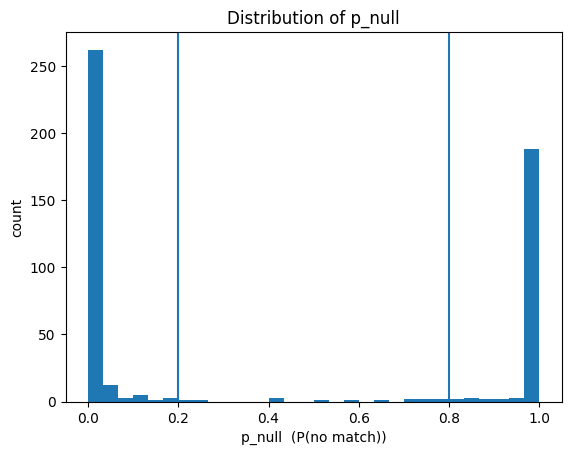

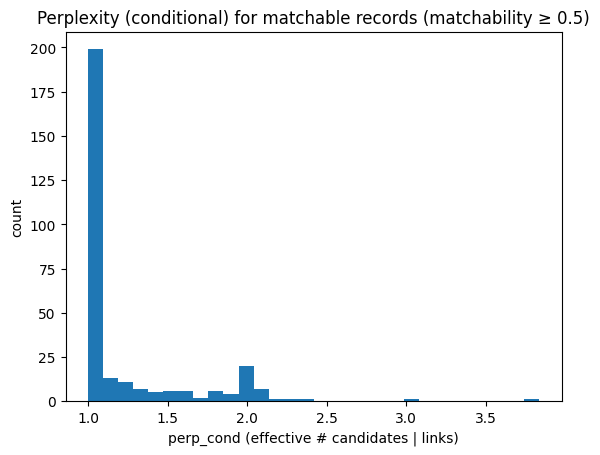

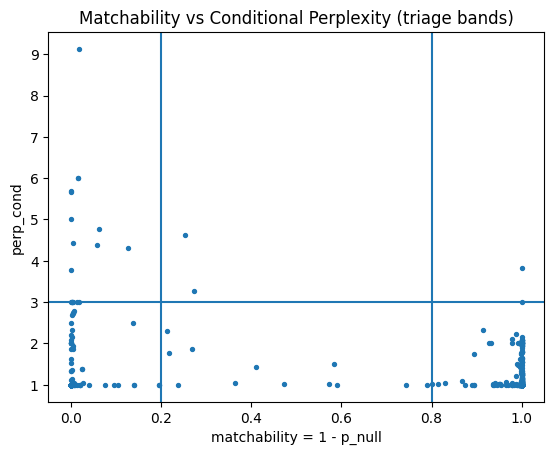

{'> 0.7': 0.412, '> 0.8': 0.4, '> 0.9': 0.386}
 unique_id_l   p_null  matchability  perp_cond    H_cond     top1   margin  abs_mid
         220 0.528116      0.471884   1.008403  0.012073 0.999020 0.998275 0.028116
         986 0.426588      0.573412   1.023424  0.033404 0.996523 0.993047 0.073412
          18 0.417135      0.582865   1.501409  0.586317 0.901783 0.838154 0.082865
         631 0.588918      0.411082   1.438386  0.524451 0.920884 0.894513 0.088918
         603 0.408855      0.591145   1.005467  0.007866 0.999402 0.999103 0.091145
         453 0.636402      0.363598   1.031137  0.044236 0.995664 0.992750 0.136402
         523 0.726465      0.273535   3.281339  1.714285 0.571456 0.356928 0.226465
         371 0.731206      0.268794   1.876186  0.907803 0.755022 0.525147 0.231206
         178 0.256896      0.743104   1.000000 -0.000000 1.000000      NaN 0.243104
         525 0.747796      0.252204   4.624570  2.209319 0.239505 0.000000 0.247796
          23 0.763330      0.

In [36]:
left_cols = ["unique_id_l", "first_name_l", "surname_l", "city_l", "dob_l"]  # adjust to your data
rm_with_left = record_metrics.merge(df_pred[left_cols].drop_duplicates("unique_id_l"),
                                    on="unique_id_l", how="left")


plot_pnull_hist(record_metrics, thresholds=(0.2, 0.8))
plot_perp_cond_hist(record_metrics, matchability_min=0.5)
plot_matchability_vs_perp(record_metrics, m_band=(0.2, 0.8), perp_thresh=3)

# subgroup example (pick a real column you have):
# subgroup_ambiguity_plot(rm_with_left, group_col="city_l", min_n=25)

# unlinkables-like shares
print(unlinkable_shares(record_metrics))

# triage top 50
q = triage_queue(record_metrics, m_band=(0.2, 0.8), perp_thresh=3, top_n=50)
print(q.head(20).to_string(index=False))


In [37]:
bins = pd.cut(
    rm_with_left["p_null"],
    bins=[-0.01, 0.2, 0.8, 1.01],
    labels=["likely_link", "uncertain", "very_unlinkable"]
)
rm_with_left.groupby(["city_l", bins]).size().unstack(fill_value=0)

C:\Users\uctvjla\AppData\Local\Temp\ipykernel_29024\3781602124.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rm_with_left.groupby(["city_l", bins]).size().unstack(fill_value=0)


p_null,likely_link,uncertain,very_unlinkable
city_l,,,
Aberdeen,8,0,0
Abereden,1,0,0
Belfast,2,0,3
Bimingmah,0,0,1
Birgmhniam,1,0,0
...,...,...,...
dLondon,1,0,0
fTelford,1,0,0
kYorY,0,0,1
